In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, Galactic,  cartesian_to_spherical
import matplotlib.pyplot as plt
from healpy import projview

import pyccl as ccl
from scipy import integrate
import pyccl as ccl
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
# EDUARDA: primeiro passo, gerar os hemisférios (mantive as linhas originais que você escreveu)


# vamos definir os parâmetros de pixelização (nside=2 produz 48 calotas esféricas)

nside = 2
npix = hp.nside2npix(nside)

In [3]:
# EDUARDA: O que tinha comentado, eu apaguei

# Vamos obter as coordenadas dos centros dos pixels para nside=2

lon, lat = hp.pix2ang(nside, range(npix), lonlat=True)

galactic_coords = SkyCoord(l=lon, b=lat, frame='galactic', unit='deg')
equatorial_coords = galactic_coords.icrs #transform_to('icrs')

ra_pixel = equatorial_coords.ra.deg
dec_pixel = equatorial_coords.dec.deg

In [4]:
# EDUARDA:se o seu arquivo já é csv, não precisa colocar o sep=' ', 
#só se ele não abrir corretamente, então você verifica.

#USANDO csv
data = pd.read_csv('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES.csv', sep=' ')
data

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,106,1.61505,0.00545,1.61499,0.00500,1.61399,0.00500,25.90650,0.331927,...,1.7256,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002
1697,geta,106,1.69706,0.04006,1.69702,0.04000,1.70000,0.04000,26.03330,0.379521,...,1.8973,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000
1698,stone,106,1.80119,0.02014,1.80111,0.02000,1.80000,0.02000,26.23350,0.280685,...,1.1631,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000
1699,wilson,106,1.91165,0.00263,1.91160,0.00100,1.91401,0.00100,26.17030,0.357624,...,1.4902,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000


In [5]:
# EDUARDA: vou seguir tua ideia original, fiz uma pequena alteração

index = []
for i in range(1701):
    index.append(i)
    
data['index'] = index

In [6]:
# EDUARDA: novamente, mantive seu curso original

data = data[data['zCMB'] >= 0.01]
print(len(data))

ra_data = data['RA']* np.pi / 180
dec_data = data['DEC']* np.pi / 180

1588


In [7]:
# Raio do círculo em graus
raio = 90

n = 47
cont = 0

while cont <= n:
    
    # Coordenadas do centro do círculo/pixel em radianos
    ra_centro = ra_pixel[cont]* np.pi / 180
    dec_centro = dec_pixel[cont]* np.pi / 180
    
    # Usando a fórmula de Haversine
    delta_ra = ra_data - ra_centro
    delta_dec = dec_data - dec_centro
    
    a = np.sin(delta_dec / 2)**2 + np.cos(dec_centro) * np.cos(dec_data) * np.sin(delta_ra / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distancia = np.degrees(c)
    objetos = data[distancia <= raio]
    
    local = f'/home/sofia/Documentos/Pantheon/Atividade 3/Hemisferios/{cont:03d}.csv'
    objetos.to_csv(local, index=False)
 
    cont += 1

In [8]:
# EDUARDA: agora vamos fazer os melhores ajustes através dos dois métodos.

index = []
zCMB = []
MU_SHOES = []

for i in range(48):
    di = f'/home/sofia/Documentos/Pantheon/Atividade 3/Hemisferios/{i:03d}.csv'

    hemis = pd.read_csv(di)
    index.append(hemis['index'].values)
    zCMB.append(hemis['zCMB'].values)
    MU_SHOES.append(hemis['MU_SH0ES'].values)

In [9]:
cove = np.genfromtxt('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES_STAT+SYS.cov', skip_header=1)
cov = np.reshape(cove, (1701, 1701))

In [10]:
# EDUARDA: mantive sua notação original e acrescentei a do pyCCL

def mu_fit_integral(z, H0, Om):
    c = 299793.458
    Om_lamb = 1 - Om

    def integrando(z):
        return 1 / np.sqrt(Om * (1 + z)**3 + Om_lamb)

    mu_values = []

    for z_val in z:
        I, _ = integrate.quad(integrando, 0, z_val) 
        dL = (c / H0) * (1 + z_val) * I
        mu = 5 * np.log10(dL) + 25
        mu_values.append(mu)

    return np.array(mu_values)


def mu_fit_ccl(z, Om0, h0):
    
    cosmo = ccl.Cosmology(
        Omega_c= Om0-0.0494, Omega_b=0.0494, 
        h=h0, sigma8=0.8120, n_s=0.9649)
    
    a = 1/(1+z)
    
    return ccl.background.distance_modulus(cosmo, a)

In [11]:
# EDUARDA: Eu adaptei e corrigi a ordem dos parâmetros. usei '_i' para integral e '_c' para ccl

H0_i = []
Om_i = []

H0_c = []
Om_c = []

for i in range(48):
    
    I_h = np.int64(index[i])
    E_h = cov[np.ix_(I_h, I_h)]
    
    p0_i = [70, 0.3]
    curve_i, cove_i = curve_fit(mu_fit_integral, zCMB[i], MU_SHOES[i], 
                                p0=p0_i, sigma=E_h, method='trf')
    print(curve_i)
    H0_i.append(curve_i[0])
    Om_i.append(curve_i[1])

    curve_c, cove_c = curve_fit(mu_fit_ccl, zCMB[i], MU_SHOES[i], bounds=([0, 0],[1, 1]), sigma=E_h, 
                            method='trf')
        
    print(curve_c)
    H0_c.append(100 * np.array(curve_c[1]))
    Om_c.append(curve_c[0])

[73.14630141  0.32513619]
[0.32500314 0.73146174]
[72.99789567  0.32831737]
[0.32818402 0.72997763]
[73.22308567  0.32290528]
[0.32277241 0.73222957]
[73.17456698  0.32571996]
[0.3255871  0.73174436]
[73.28254849  0.33314145]
[0.33300794 0.73282426]
[72.71226967  0.35925133]
[0.35911808 0.72712138]
[72.37311907  0.3596798 ]
[0.35954525 0.7237298 ]
[72.52128     0.34606308]
[0.34592861 0.72521148]
[73.05913013  0.32559856]
[0.32546479 0.73059012]
[73.27669546  0.31988833]
[0.31975494 0.73276571]
[73.34512596  0.32171069]
[0.32157781 0.73345001]
[73.4247167   0.32098815]
[0.32085559 0.73424589]
[73.40363988  0.33992243]
[0.33979328 0.73403503]
[72.8591517   0.34104661]
[0.34091229 0.7285904 ]
[72.44712864  0.35688177]
[0.35674752 0.72447007]
[72.12742008  0.3848336 ]
[0.38469888 0.72127303]
[72.64999088  0.35509541]
[0.35495984 0.72649901]
[73.19828151  0.32306507]
[0.32293241 0.73198178]
[73.63414719  0.30037343]
[0.30024255 0.73634022]
[73.80349491  0.28898442]
[0.28885807 0.73803316]


In [12]:
# EDUARDA: Vamos para a parte de gerar os mapas, novamente, acrescentei a parte do ccl,
# e mantive o máximo das suas linhas originais

H0_pix = H0_i
Om_pix = Om_i

nside = 2  
npix = hp.nside2npix(nside) 

#criar um mapa vazio e atribuir os valores de números a cada pixel dele
H0_map = np.zeros(npix)
H0_map[:len(H0_pix)] = H0_pix

Om_map = np.zeros(npix)
Om_map[:len(Om_pix)] = Om_pix

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 3/H0_map_i.fits', H0_map, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 3/Om_map_i.fits', Om_map, overwrite=True)


H0_map_c = np.zeros(npix)
H0_map_c[:len(H0_c)] = H0_c

Om_map_c = np.zeros(npix)
Om_map_c[:len(Om_c)] = Om_c

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 3/H0_map_ccl.fits', H0_map_c, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 3/Om_map_ccl.fits', Om_map_c, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [13]:
fontsize = {
"xlabel": 15,           # Tamanho da fonte do rótulo do eixo x
"ylabel": 15,           # Tamanho da fonte do rótulo do eixo y
"title": 20,            # Tamanho da fonte do título
"xtick_label": 15,      # Tamanho da fonte dos rótulos do eixo x
"ytick_label": 15,      # Tamanho da fonte dos rótulos do eixo y
"cbar_label": 15,       # Tamanho da fonte da legenda da barra de cores
"cbar_tick_label": 15   # Tamanho da fonte dos rótulos da barra de cores
}

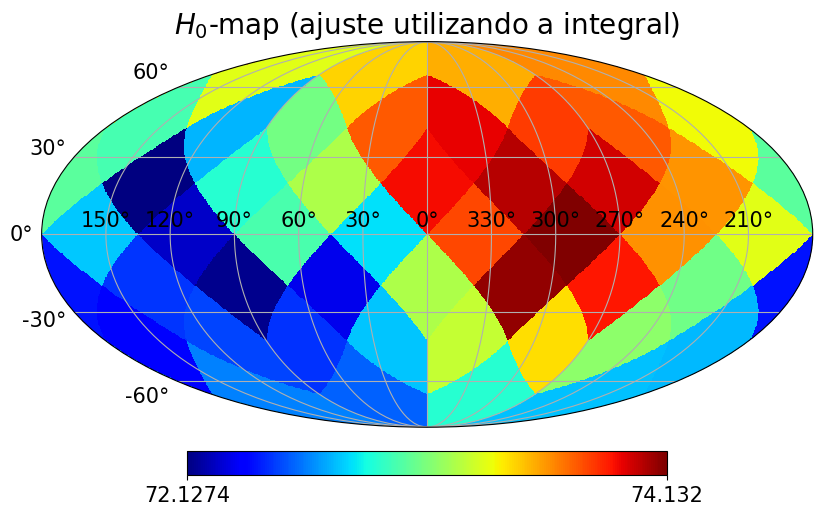

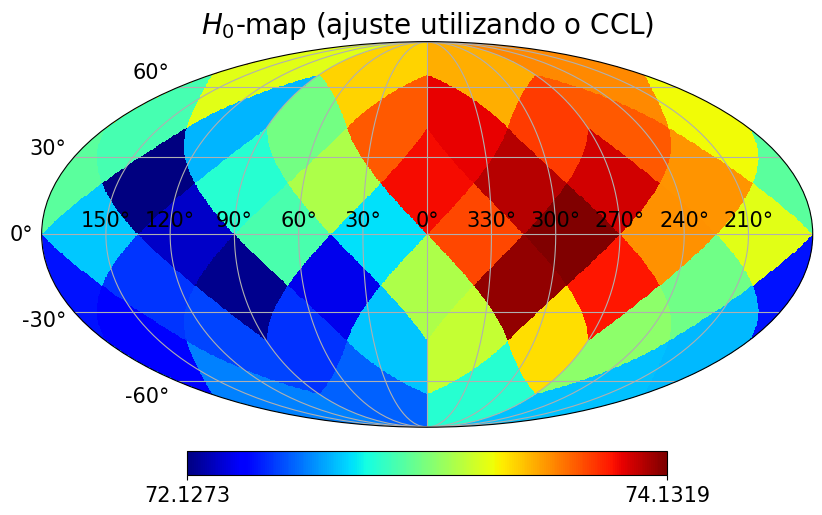

In [14]:
projview(H0_map,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando a integral)",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 3/H0_map_int.png', dpi=600, bbox_inches='tight')

projview(H0_map_c,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando o CCL)",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 3/H0_map_ccl.png', dpi=600, bbox_inches='tight')

plt.show()

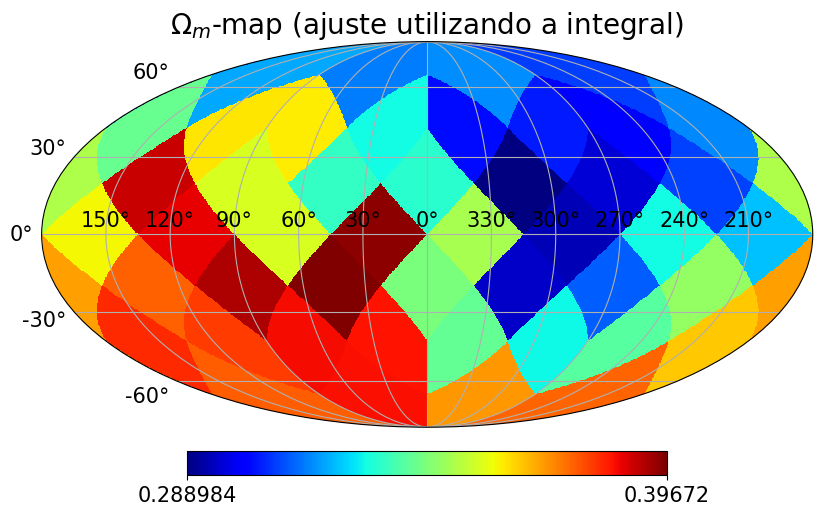

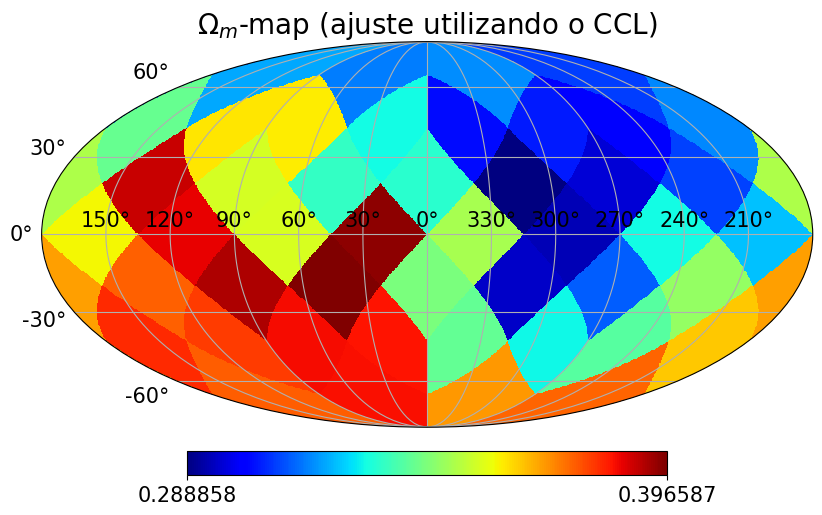

In [15]:
projview(Om_map,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando a integral)",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 3/Om_map_int.png', dpi=600, bbox_inches='tight')

projview(Om_map_c,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando o CCL)",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 3/Om_map_ccl.png', dpi=600, bbox_inches='tight')

plt.show()